# Data Exploration

In [1]:
import numpy as np
import scipy.ndimage as ndi
import imageio as imio
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd

# Explore Data

In [2]:
RAW_IMAGES_PATH = '../../data/raw_data/malaria/images/'
BOUNDING_BOX_PATH =  '../../data/raw_data/malaria/'

In [ ]:
train_images_paths = os.listdir(RAW_IMAGES_PATH)

In [ ]:
train_images_paths

In [ ]:
train_images = []
train_images_gray_scale = []
train_images_shape = []

for i in train_images_paths:
    new_image = imio.imread(RAW_IMAGES_PATH+i)
    train_images.append(new_image)
    train_images_gray_scale.append(new_image[:,:,0])
    train_images_shape.append(new_image.shape)
    

In [ ]:
train_images_shape =  np.array(train_images_shape)

### Number of images in data set

In [ ]:
len(train_images)

#### Test random image

In [ ]:
plt.imshow(train_images[5])

In [ ]:
fig, axes = plt.subplots(2,3)
axes[0,0].imshow(train_images[5])
axes[1,0].imshow(train_images[2])

axes[0,1].imshow(train_images[10])
axes[1,1].imshow(train_images[4])

axes[0,2].imshow(train_images[15])
axes[1,2].imshow(train_images[6])


#fig = plt.gcf()
#for ax in fig.axes:
#    ax.axis('off')
plt.tight_layout()
plt.show()

## Images Shape

##### Get percentile, distribution of the height,weigth and area of images

In [ ]:
train_images[5].shape

### Heights

In [ ]:
heights = train_images_shape[:,0]

In [ ]:
print('MEAN     : ' , np.mean(heights))
print('MAX VALUE: ' , np.amax(heights))
print('MIN VALUE: ' , np.amin(heights))
print('PCTL 25% : ' , np.percentile(heights, 25))
print('PCTL 50% : ' , np.percentile(heights, 50))
print('PCTL 75% : ' , np.percentile(heights, 75))

In [ ]:
sns.distplot(heights)

### Widths

In [ ]:
widths = train_images_shape[:,1]

In [ ]:
print('MEAN     : ' , np.mean(widths))
print('MAX VALUE: ' , np.amax(widths))
print('MIN VALUE: ' , np.amin(widths))
print('PCTL 25% : ' , np.percentile(widths, 25))
print('PCTL 50% : ' , np.percentile(widths, 50))
print('PCTL 75% : ' , np.percentile(widths, 75))

In [ ]:
sns.distplot(widths)

# TRANSFORM IMAGES

In [3]:
import os
import sys
import random
import warnings
import cv2

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label


In [4]:
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

## Load TRAIN dataset

In [ ]:
train_bounding_box_df = pd.read_json(BOUNDING_BOX_PATH + 'training.json')
train_bounding_box_df['path'] = train_bounding_box_df['image'].map(lambda x: BOUNDING_BOX_PATH + x['pathname'][1:])

print(train_bounding_box_df.shape[0], 'images')
print(train_bounding_box_df.shape[0], 'images available')
train_bounding_box_df.sample(5)

In [ ]:
objects = []
for im_index, c_row in train_bounding_box_df.iterrows():
    for c_item in c_row['objects']:
        c_item.update({'im_index':im_index})
        objects.append(dict(image=c_row['path'], **c_item))
        
object_df = pd.DataFrame(objects)


In [ ]:
#object_df = pd.DataFrame([dict(image=c_row['path'], **c_item) for im_index, c_row in train_bounding_box_df.iterrows() for c_item in c_row['objects']])
cat_dict = {v:k for k,v in enumerate(object_df['category'].value_counts().index, 1)}
print(object_df['category'].value_counts())
object_df.sample(3)

In [ ]:
cat_dict

## Transform Data

### Parameters

In [21]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRANSFORMED_PATH = '../../data/raw_data/malaria/transformed_images/'
GENERATED_MASK_PATH = '../../data/raw_data/malaria/masks/'

In [ ]:
# Get and resize train images and masks
total_images = train_bounding_box_df.shape[0]
#X_train = np.zeros((total_images, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
#masks_train = np.zeros((total_images, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
X_train = []
masks_train = []

In [ ]:
object_df.count()

In [ ]:
print('Getting and resizing train images  ... ')
sys.stdout.flush()

for n, row in tqdm(train_bounding_box_df.iterrows(), total=total_images):
    img_path = row['path']
    img = imread( img_path )[:,:,:IMG_CHANNELS]
    
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train.append(img)
    masks_train.append( np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8) )
   
    

In [ ]:
print('Generating masks ... ')
sys.stdout.flush()

for n, row in tqdm(object_df.iterrows(), total=object_df.count()):
    #print(row)
    min_val = row['bounding_box']['minimum']
    max_val = row['bounding_box']['maximum']
    im_index = row['im_index']
    
    if(row['category'] in ['trophozoite','ring', 'schizont']) :
        mask =  masks_train[im_index]
        mask[slice(min_val['r'], max_val['r']), slice(min_val['c'], max_val['c'])] = 1
        masks_train[im_index] = mask
   
    

In [ ]:
plt.imshow(X_train[0])

In [ ]:
plt.imshow(masks_train[0])

In [ ]:
from skimage.color import label2rgb

In [ ]:
plt.imshow(label2rgb(label=masks_train[0], image=X_train[0], bg_label=0))

## TEST dataset

In [5]:
X_test = []
masks_test = []

In [7]:
test_bounding_box_df = pd.read_json(BOUNDING_BOX_PATH + 'test.json')
test_bounding_box_df['path'] = test_bounding_box_df['image'].map(lambda x: BOUNDING_BOX_PATH + x['pathname'][1:])

print(test_bounding_box_df.shape[0], 'images')
print(test_bounding_box_df.shape[0], 'images available')


120 images
120 images available


In [8]:
objects_test = []
for im_index, c_row in test_bounding_box_df.iterrows():
    for c_item in c_row['objects']:
        c_item.update({'im_index':im_index})
        objects_test.append(dict(image=c_row['path'], **c_item))
        
object_test_df = pd.DataFrame(objects_test)

In [10]:
total_test_images = test_bounding_box_df.shape[0]
total_test_images

120

In [11]:
print('Getting and resizing test images  ... ')
sys.stdout.flush()

for n, row in tqdm(test_bounding_box_df.iterrows(), total=total_test_images):
    img_path = row['path']
    img = imread( img_path )[:,:,:IMG_CHANNELS]
    
    ## Create image mask
    masks_test.append( np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8) )
    
    ## Reshape image
    #img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test.append(img)
    
   

Getting and resizing test images  ... 


100%|██████████| 120/120 [00:03<00:00, 37.11it/s]


In [15]:
print('Generating test masks ... ')
sys.stdout.flush()
object_test_df_count = object_test_df.shape[0]
for n, row in tqdm(object_test_df.iterrows(), total=object_test_df_count):

    min_val = row['bounding_box']['minimum']
    max_val = row['bounding_box']['maximum']
    im_index = row['im_index']
    
    if(row['category'] in ['trophozoite','ring', 'schizont', 'gametocyte']) :
        mask =  masks_test[im_index]
        mask[slice(min_val['r'], max_val['r']), slice(min_val['c'], max_val['c'])] = 1
        masks_test[im_index] = mask

Generating test masks ... 


100%|██████████| 5922/5922 [00:00<00:00, 11276.66it/s]


#### Reshape Masks

In [ ]:
masks_test_transformed = []
for mask in masks_test:
    new_mask = cv2.resize(masks_test[0], dsize=(256,256), interpolation=cv2.INTER_NEAREST)
    masks_test_transformed.append(new_mask)

(1383, 1944)
0.18510484454085321
0.13168724279835392
(256, 256)


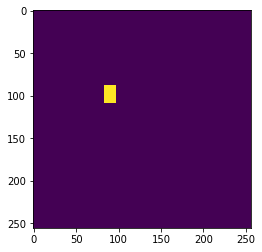

In [29]:
print(masks_test[0].shape)
print(256/1383)
print(256/1944)

#temp = imresize(masks_test[0], size=(256,256), interp='bilinear')
temp = cv2.resize(masks_test[0], dsize=(256,256), interpolation=cv2.INTER_NEAREST)
temp = ndi.binary_erosion(temp, iterations=5)
print(temp.shape)
plt.imshow(temp)

In [ ]:
plt.imshow(masks_test[0])

In [ ]:
plt.imshow(X_test[0])

In [ ]:
plt.imshow(X_test[0], )    # Also set the cmap to gray
plt.imshow(np.where(masks_test[0]>0, 1, np.nan), cmap='rainbow',alpha=0.4)

## SAVE DATA

### TRAINING DATASET

In [24]:
train_dataset_name = 'malaria_train_transformed_' + str(IMG_WIDTH) + '_' + str(IMG_HEIGHT)
print(train_dataset_name)
print(train_dataset_name + '_names')
print(train_dataset_name + '_masks')

malaria_train_transformed_256_256
malaria_train_transformed_256_256_names
malaria_train_transformed_256_256_masks


In [ ]:
np.save(TRANSFORMED_PATH + train_dataset_name , X_train)

In [ ]:
np.save(TRANSFORMED_PATH + train_dataset_name + '_names', train_bounding_box_df['path'])

In [ ]:
np.save(TRANSFORMED_PATH + train_dataset_name + '_masks', masks_train)

### TEST DATASET

In [25]:
test_dataset_name = 'malaria_test_transformed_' + str(IMG_WIDTH) + '_' + str(IMG_HEIGHT)
print(test_dataset_name)
print(test_dataset_name + '_names')
print(test_dataset_name + '_masks')

malaria_test_transformed_256_256
malaria_test_transformed_256_256_names
malaria_test_transformed_256_256_masks


In [ ]:
np.save(TRANSFORMED_PATH + test_dataset_name, X_test)

In [ ]:
np.save(TRANSFORMED_PATH + test_dataset_name + '_names', test_bounding_box_df['path'])

In [ ]:
np.save(TRANSFORMED_PATH + test_dataset_name + '_masks', masks_test)